# Code Beispiel

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch

Installing the segment-anything library

In [57]:
# !pip install git+https://github.com/facebookresearch/segment-anything.git

Model checkpoints can be downloaded from https://github.com/facebookresearch/segment-anything#model-checkpoints

In [58]:
model_folder_path = r".\segment_anything_models"
model_file_names = {"vit_h": "sam_vit_h_4b8939.pth",
                    "vit_b": "sam_vit_b_01ec64.pth", 
                    "vit_l": "sam_vit_l_0b3195.pth"}

### Example Image

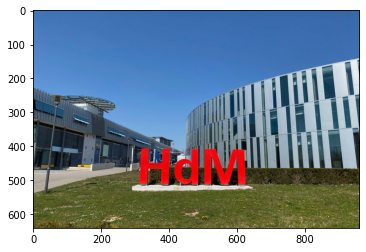

In [59]:
image = cv2.imread('./sample_imgs/hdm.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image);

### 1. Point Prompt

In [60]:
from segment_anything import sam_model_registry, SamPredictor

**Load SAM model checkpoint and optionally set device to CUDA**

In [61]:
used_model = "vit_h"
sam = sam_model_registry[used_model](checkpoint=os.path.join(model_folder_path, model_file_names[used_model]))
#sam.to(device="cuda")

predictor = SamPredictor(sam)

**Creating Image Embedding**

In [62]:
predictor.set_image(image)

**Creating Point Prompt** <br>
Point Prompts need x,y coordinates and a label classifying if the point will be in the foreground or beackground of the mask.

In [63]:
input_point = np.array([[390, 450]])
input_label = np.array([1])  #  labels 1 (foreground point) or 0 (background point)

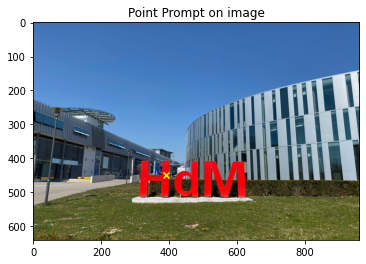

In [64]:
plt.imshow(image)
plt.scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
plt.title("Point Prompt on image")
plt.show();

**Mask Prediction** <br>
Use the `.predict()` function from the initialized `predictor` class to generate masks from the provided prompts

In [65]:
# Predicting masks based on one input prompt
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

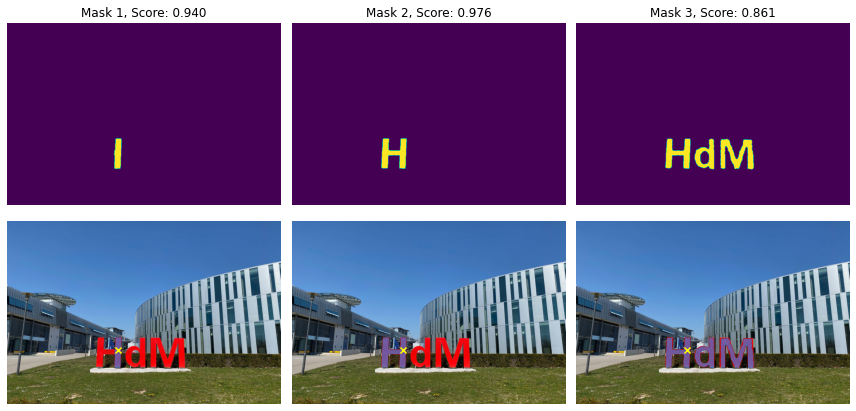

In [66]:
# Display masks in plot
color = np.array([30/255, 144/255, 255/255, 0.6])
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, (mask, score) in enumerate(zip(masks, scores)):
    axs[0, i].set_title(f"Mask {i+1}, Score: {score:.3f}")
    axs[0, i].imshow(mask)
    axs[0, i].axis('off')
    
    axs[1, i].imshow(image)
    axs[1, i].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
    axs[1, i].imshow(mask.reshape(mask.shape[0], mask.shape[1], -1) * color.reshape(1, 1, -1))
    axs[1, i].axis('off')
    
fig.tight_layout()
plt.show();

**Multiple Point Prompts** <br>
By providing multiple point prompts to the predictor, ambiguity can be avoided.

In [67]:
input_point = np.array([[390, 450], [600, 425]])
input_label = np.array([1, 1])  #  labels 1 (foreground point) or 0 (background point)

In [68]:
# Predicting masks based on two input prompts
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=False,
)

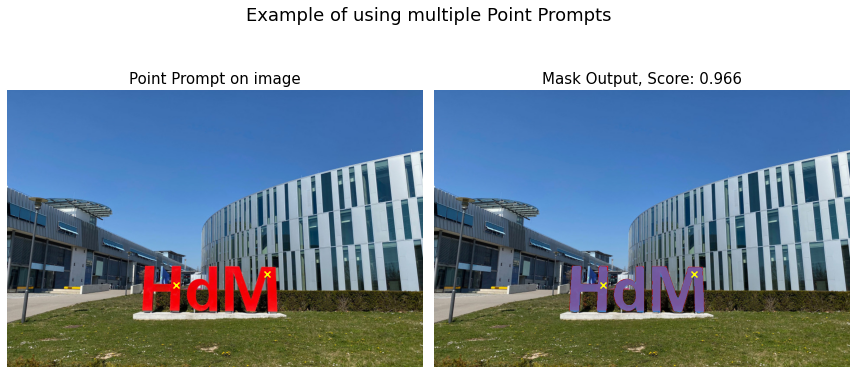

In [69]:
# Display masks in plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("Point Prompt on image", size=15)
axs[0].imshow(image)
axs[0].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
axs[0].scatter(input_point[1, 0], input_point[1, 1], marker="x", color="yellow")
axs[0].axis('off')

axs[1].set_title(f"Mask Output, Score: {scores[0]:.3f}", size=15)
axs[1].imshow(image)
axs[1].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="yellow")
axs[1].scatter(input_point[1, 0], input_point[1, 1], marker="x", color="yellow")
axs[1].imshow(masks[0].reshape(masks[0].shape[0], masks[0].shape[1], -1) * color.reshape(1, 1, -1))
axs[1].axis('off')

fig.suptitle("Example of using multiple Point Prompts", size=18)
fig.tight_layout()
plt.show()
# IMAGE CREDIT: Lout. “Young Professionals der HdM stellen sich vor.” Lout.plus, 2021, https://lout.plus/Experten/Young-Professionals-der-HdM-stellen-sich-vor.html.

**Bounding Box Prompts**

In [70]:
bb_image = cv2.imread('./sample_imgs/mike.png')
bb_image = cv2.cvtColor(bb_image, cv2.COLOR_BGR2RGB)

predictor.set_image(bb_image)

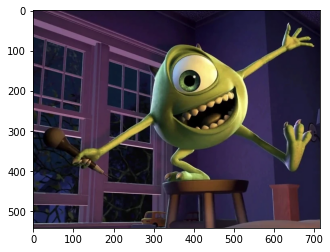

In [71]:
plt.imshow(bb_image);
#Image Credit: Monsters, Inc. 2001. Pixar Animation Studios and Walt Disney Pictures.

Bounding box prompts need two Points specifying the top-left and the bottom-right points of the box.

In [72]:
input_box = np.array([280, 80, 550, 350])  # x1, y1, x2, y2
input_point = np.array([[400, 150], [450, 250]])
input_label = np.array([0, 0])

In [73]:
# Predicting mask based on only a bounding box prompt
bb_mask, _, _ = predictor.predict(
    box=input_box,
    multimask_output=False,
)

In [74]:
# Predicting mask based on bounding box and background point prompt
combined_mask, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

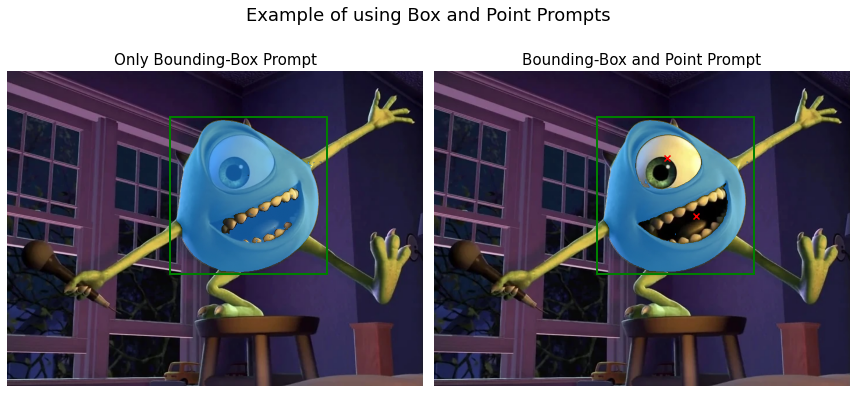

In [80]:
# Display masks in plot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].set_title("Only Bounding-Box Prompt", size=15)
axs[0].imshow(bb_image)
axs[0].imshow(bb_mask[0].reshape(bb_mask[0].shape[0], bb_mask[0].shape[1], -1) * color.reshape(1, 1, -1))
axs[0].add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2]-input_box[0], input_box[3]-input_box[1], edgecolor='green', facecolor=(0,0,0,0), lw=2))    
axs[0].axis('off')

axs[1].set_title("Bounding-Box and Point Prompt", size=15)
axs[1].imshow(bb_image)
axs[1].scatter(input_point[0, 0], input_point[0, 1], marker="x", color="red")
axs[1].scatter(input_point[1, 0], input_point[1, 1], marker="x", color="red")
axs[1].add_patch(plt.Rectangle((input_box[0], input_box[1]), input_box[2]-input_box[0], input_box[3]-input_box[1], edgecolor='green', facecolor=(0,0,0,0), lw=2))    
axs[1].imshow(combined_mask[0].reshape(combined_mask[0].shape[0], combined_mask[0].shape[1], -1) * color.reshape(1, 1, -1))
axs[1].axis('off')

fig.suptitle("Example of using Box and Point Prompts", size=18)
fig.tight_layout()
plt.show()

**Detecting multiple Masks at once**
When multiple masks need to be detected, the prompts need to be in a torch tensor. Additionaly the `.predict_torch()` function of the `predictor` needs to be used.

In [76]:
input_boxes = torch.tensor([[300, 400, 540, 540], [100, 50, 700, 450], [30, 280, 200, 420]],
                         device=predictor.device)  # x1, y1, x2, y2

transformed_boxes = predictor.transform.apply_boxes_torch(input_boxes, bb_image.shape[:2])

In [77]:
# Predicting multiple masks at once using predict_torch()
tensor_masks, _, _ = predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False,
)

In [78]:
tensor_masks.shape

torch.Size([3, 1, 542, 715])

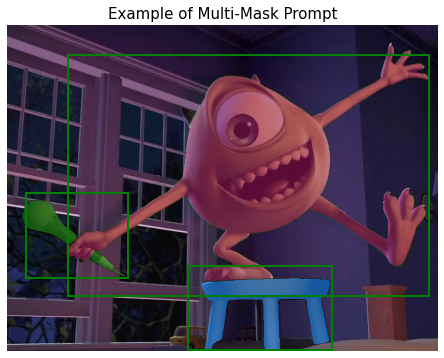

In [79]:
# Display masks in plot
colors = np.array([[30/255, 144/255, 255/255, 0.6], [150/255, 20/255, 90/255, 0.6], [30/255, 144/255, 30/255, 0.6]])
fig, axs = plt.subplots(1, 1, figsize=(12, 6))
axs.imshow(bb_image)

for i, mask in enumerate(tensor_masks):
    axs.imshow(mask.numpy()[0].reshape(mask.numpy()[0].shape[0], mask.numpy()[0].shape[1], -1) * colors[i].reshape(1, 1, -1))

for box in input_boxes:
    box = box.numpy()
    axs.add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], edgecolor='green', facecolor=(0,0,0,0), lw=2))   
plt.axis('off')
plt.title("Example of Multi-Mask Prompt", size=15)
plt.show()